## Sentiment Analysis for Twitter Dataset


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import precision_recall_curve, confusion_matrix,classification_report
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkhatiwada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../data/three_tweets.csv')
df.head()

,tweet_id,sentiment,author,content
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,unpleasant,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,unpleasant,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,pleasant,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


**For the classification of sentiments, we are intereseted in the content and sentiment part ony. So, we select the particular columns the dataframe.**

In [3]:
columns = ['content','sentiment']
filteredDf = df[columns]
filteredDf.head()

,content,sentiment
0,@tiffanylue i know i was listenin to bad habi...,neutral
1,Layin n bed with a headache ughhhh...waitin o...,unpleasant
2,Funeral ceremony...gloomy friday...,unpleasant
3,wants to hang out with friends SOON!,pleasant
4,@dannycastillo We want to trade with someone w...,neutral


**We use one hot encoding to convert the sentiments labels to numeric form.**

In [4]:
onehotSentiment = pd.get_dummies(filteredDf['sentiment'])
onehotSentiment.head()

,neutral,pleasant,unpleasant
0,1,0,0
1,0,0,1
2,0,0,1
3,0,1,0
4,1,0,0


In [5]:
filteredDf= filteredDf.join(onehotSentiment)
filteredDf.head()

,content,sentiment,neutral,pleasant,unpleasant
0,@tiffanylue i know i was listenin to bad habi...,neutral,1,0,0
1,Layin n bed with a headache ughhhh...waitin o...,unpleasant,0,0,1
2,Funeral ceremony...gloomy friday...,unpleasant,0,0,1
3,wants to hang out with friends SOON!,pleasant,0,1,0
4,@dannycastillo We want to trade with someone w...,neutral,1,0,0


**The content fielf of dataframe contains some URLs and special characters. So we remove them as they are not important in describing the sentiments.**

In [6]:
#remove url in the content
filteredDf['content'] = filteredDf['content'].replace(r'http\S+', '', regex=True)
#removing the special characters like @, # ,%
removeChar = str.maketrans('', '', '&@#%')
filteredDf['content'] = [s.translate(removeChar) for s in filteredDf['content']]
stpwords = set(STOPWORDS)# removing the stop words.

In [7]:
def wordCloud(text):
    wordcloud = WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).generate(text)
    return wordcloud

In [8]:
def plotWordCloud(wordcloud):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [9]:
words = " ".join(line.strip() for line in filteredDf.content)


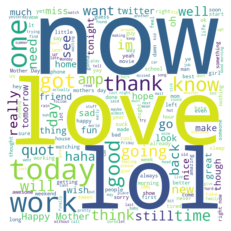

In [10]:
wordcloudAllContents = wordCloud(words)
plotWordCloud(wordcloudAllContents)

**The above wordcloud shows the common words for every sentiments.**

**Now we are going to see which words are important to describe three sentiments: neutral, pleasant and unpleasant using logistic regression.**

## Logistic Regression

In [11]:
stop_words = stopwords.words('english')
countVect = CountVectorizer(binary=False, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             min_df=5,max_df=0.95)
features = countVect.fit_transform(filteredDf.content)
allFeatures = countVect.get_feature_names()

**Since there are 3 sentiments, we use 3 logistic regressions keeping one sentiment label as 1 at a time and keeping two other labels as 0( done by one hot encoding).** 

**For each label, we split the dataset into training and testing dataset and perform binary classification. We have used grid search for corss validation.**



In [12]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features,filteredDf.neutral , test_size=0.1, random_state=6)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features,filteredDf.pleasant , test_size=0.1, random_state=6)
X_train3, X_test3, y_train3, y_test3 = train_test_split(features,filteredDf.unpleasant , test_size=0.1, random_state=6)



In [14]:
def model(X_train,y_train):
    params = {
        'C':[0.07,0.09,0.1,0.2,0.3,0.5,1]
    }

    logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1,class_weight='balanced')
    gridSearch = GridSearchCV(logisticModel, params,verbose=3,n_jobs=-1)
    gridSearch.fit(X_train,y_train)

    return(gridSearch.best_estimator_)

In [16]:
modelNeutral = model(X_train1, y_train1)
print(modelNeutral)
dump(modelNeutral, '../models/neutralClassifier_twitter.joblib')

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.1s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=6, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


['../models/neutralClassifier_twitter.joblib']

In [17]:
modelPleasant = model(X_train2, y_train2)
print(modelPleasant)
dump(modelPleasant, '../models/pleasantClassifier_twitter.joblib')

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


LogisticRegression(C=0.07, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=6, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    6.5s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


['../models/pleasantClassifier_twitter.joblib']

In [18]:
modelUnpleasant = model(X_train3, y_train3)
print(modelUnpleasant)
dump(modelUnpleasant, '../models/unpleasantClassifier_twitter.joblib')

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.7s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=6, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


['../models/unpleasantClassifier_twitter.joblib']

In [19]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

the accuracy of training set is :0.70075
the accuracy of testing set is :0.61725
[[1600 1082]
 [ 449  869]]
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      2682
           1       0.45      0.66      0.53      1318

    accuracy                           0.62      4000
   macro avg       0.61      0.63      0.60      4000
weighted avg       0.67      0.62      0.63      4000



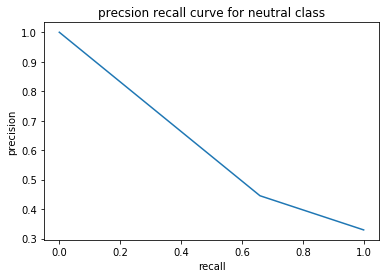

In [20]:
loadedModel = load('../models/neutralClassifier_twitter.joblib')
trainPredict1LR = loadedModel.predict(X_train1)
accuracyLR1train = accuracy_score(y_train1, trainPredict1LR)
print("the accuracy of training set is :{}".format(accuracyLR1train))

testPredict1LR = loadedModel.predict(X_test1)
accuracyLR1test = accuracy_score(y_test1, testPredict1LR)
print("the accuracy of testing set is :{}".format(accuracyLR1test))

print(confusion_matrix(y_test1,testPredict1LR))
print(classification_report(y_test1,testPredict1LR))
precision, recall, threshold = precision_recall_curve(y_test1,testPredict1LR)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precsion recall curve for neutral class')                   
plt.show()

the accuracy of training set is :0.7769722222222222
the accuracy of testing set is :0.7475
[[2264  615]
 [ 395  726]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2879
           1       0.54      0.65      0.59      1121

    accuracy                           0.75      4000
   macro avg       0.70      0.72      0.70      4000
weighted avg       0.76      0.75      0.75      4000



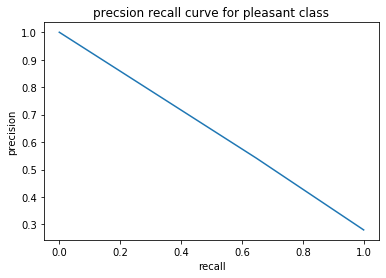

In [21]:
modelPleasant = load('../models/pleasantClassifier_twitter.joblib')
trainPredict2LR = modelPleasant.predict(X_train2)
accuracyLR2train = accuracy_score(y_train2, trainPredict2LR)
print("the accuracy of training set is :{}".format(accuracyLR2train))

testPredict2LR = modelPleasant.predict(X_test2)
accuracyLR2test = accuracy_score(y_test2, testPredict2LR)
print("the accuracy of testing set is :{}".format(accuracyLR2test))

print(confusion_matrix(y_test2,testPredict2LR))
print(classification_report(y_test2,testPredict2LR))
precision, recall, threshold = precision_recall_curve(y_test2,testPredict2LR)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precsion recall curve for pleasant class') 
plt.show()

the accuracy of training set is :0.76675
the accuracy of testing set is :0.70475
[[1809  630]
 [ 551 1010]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      2439
           1       0.62      0.65      0.63      1561

    accuracy                           0.70      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.71      0.70      0.71      4000



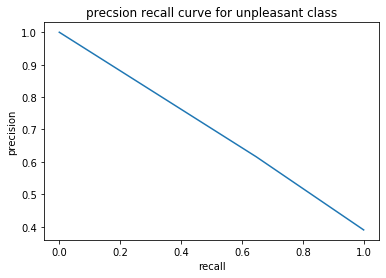

In [23]:
modelUnpleasant = load('../models/unpleasantClassifier_twitter.joblib')
trainPredict3LR = modelUnpleasant.predict(X_train3)
accuracyLR3train = accuracy_score(y_train3, trainPredict3LR)
print("the accuracy of training set is :{}".format(accuracyLR3train))

testPredict3LR = modelUnpleasant.predict(X_test3)
accuracyLR3test = accuracy_score(y_test3, testPredict3LR)
print("the accuracy of testing set is :{}".format(accuracyLR3test))

print(confusion_matrix(y_test3,testPredict3LR))
print(classification_report(y_test3,testPredict3LR))
precision, recall, threshold = precision_recall_curve(y_test3,testPredict3LR)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precsion recall curve for unpleasant class') 
plt.show()

In [31]:
neutralEg = {}
indicesForNeutralEg = np.argsort(-1*modelNeutral.coef_)[:,0:100][0]
for i in indicesForNeutralEg[0:100]:
    neutralEg[allFeatures[i]] = modelNeutral.coef_[0,i]


In [32]:
dict(list(neutralEg.items())[0:10])

{'professional': 1.3045995019795202,
 'coulda': 1.2612557783101692,
 'spray': 1.197052190820412,
 'ship': 1.1596248108413878,
 'confirmed': 1.1390109387205554,
 'gut': 1.1238480814270304,
 'relief': 1.0737745343135718,
 'madre': 1.0577456850341638,
 'chu': 1.0411500638053592,
 'size': 1.021872404112303}

**The above list shows 10 top words having high feature importance responsible for classifying neutral sentiments.**

In [33]:
pleasantEg = {}
indicesForPleasantEg = np.argsort(-1*modelPleasant.coef_)[:,0:100][0]
for i in indicesForPleasantEg[0:100]:
    pleasantEg[allFeatures[i]] = modelPleasant.coef_[0,i]


In [34]:
dict(list(pleasantEg.items())[0:10])

{'love': 1.5400750100011658,
 'awesome': 1.365379174685966,
 'happy': 1.3363442525891633,
 'excited': 1.3250622291828258,
 'amazing': 1.2014371958687065,
 'fun': 1.1922011365902137,
 'great': 1.134455542731601,
 'cute': 1.103021995161011,
 'yay': 1.0866245278579625,
 'loving': 1.0789745691721542}

**Similarly, the above list shows top 10 words responsible for classifying pleasant sentiments.**

In [35]:
unpleasantEg = {}
indicesForUnpleasantEg = np.argsort(-1*modelUnpleasant.coef_)[:,0:100][0]
for i in indicesForUnpleasantEg[0:100]:
    unpleasantEg[allFeatures[i]] = modelUnpleasant.coef_[0,i]


In [36]:
dict(list(unpleasantEg.items())[0:10])

{'sad': 2.328303505982585,
 'hate': 1.7840246321469797,
 'hurts': 1.6946699456543755,
 'sorry': 1.5747837277880714,
 'poor': 1.5450916031414337,
 'sick': 1.5244596341049574,
 'sucks': 1.490164860024914,
 'hurt': 1.4429825922303625,
 'sadly': 1.4215744858963817,
 'disappointed': 1.3717693185750348}

**In the same way, the above list shows top 10 words responsible for classifying unpleasant sentiments.**

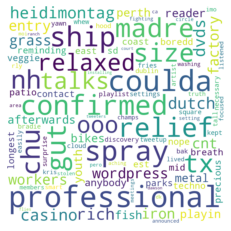

In [37]:
wordcloudNeutral = wordCloudFromFrequency(neutralEg)
plotWordCloud(wordcloudNeutral)

**The above wordcloud shows the top 100 words which are used for neutral sentiment description.**

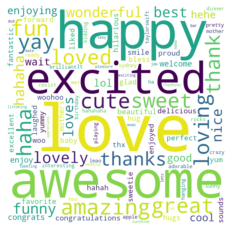

In [38]:
wordcloudPleasant = wordCloudFromFrequency(pleasantEg)
plotWordCloud(wordcloudPleasant)

**The above wordcloud shows the top 100 words used for pleasant sentiment classification.**

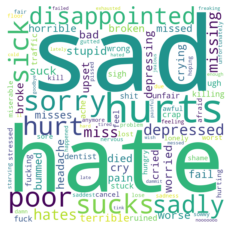

In [39]:
wordcloudUnpleasant = wordCloudFromFrequency(unpleasantEg)
plotWordCloud(wordcloudUnpleasant)

**Finally, the above wordcloud shows the top 100 words used for classifying the unpleasant sentiments.**

In [40]:
wordcloudNeutral.to_file('../reports/wordcloudTwitter/neturalUnbalanced.png')
wordcloudPleasant.to_file('../reports/wordcloudTwitter/pleasantUnbalanced.png')
wordcloudUnpleasant.to_file('../reports/wordcloudTwitter/unpleasantUnbalanced.png')